# 1. Set the path for the files

In [1]:
import os

# import os
path = os.getcwd()

# path with imr station file (pre-processed file)
path_imrstation = path+"/00_database/02_insitu_env/01_IMRstation/surface_data.csv"

# path with nibio station file
path_nibio = path+"/00_database/02_insitu_env/02_NIBIOstation/global_radiation.csv"

# path with satellite time series file
path_sat = path+"/00_database/01_input/sat.csv"

# path to save the match-up figure
path_out = path+"/01_Figures/mathcup.png"

# 2. Read and create tables for plotting

In [2]:
# library
import pandas as pd

# imr station
df_imr = pd.read_csv(path_imrstation)
df_imr = df_imr.groupby("Date").mean()
df_imr.index = pd.to_datetime(df_imr.index)
df_imr = df_imr[df_imr.index.year >=2006]

# nibio station
df_nibio = pd.read_csv(path_nibio,
                       index_col=0,
                       skiprows=3)
df_nibio.index = pd.to_datetime([x.split(" ")[0] for x in df_nibio.index])
df_nibio = df_nibio[df_nibio>=0] # remove outliers
df_nibio.columns = ["Global solar radiation"]

df_sat = pd.read_csv(path_sat, index_col=0)
df_sat.index = pd.to_datetime(df_sat.index)
df_sat = df_sat[df_sat.index.year>=2006]

# 3. Compute in situ northward and eastward wind

In [3]:
# library
import numpy as np
df_imr[["In situ wind direction"]] = (df_imr[["In situ wind direction"]]+180)%360
rad_angle = np.deg2rad(df_imr[["In situ wind direction"]])
df_imr["In situ eastward"]  = np.sin(rad_angle).multiply(df_imr.loc[:,"In situ wind speed"], axis=0)
df_imr["In situ northward"]  = np.cos(rad_angle).multiply(df_imr.loc[:,"In situ wind speed"], axis=0)

# 4. Subset and rename for facilitating plot

In [4]:
# sst
df_sst = df_sat[["sst"]].join(df_imr[["In situ temperature"]]).dropna()
df_sst.columns = ["Satellite SST (°C)", "In situ SST (°C)"]

# par
df_par = df_sat[["par"]].join(df_nibio).dropna()
df_par.columns = ["Satellite PAR (E m$^{-2}$ d)", "In situ PAR (E m$^{-2}$ d)"]

# northward wind
df_nw = df_sat[["northward_wind"]].join(df_imr[["In situ northward"]]).dropna()
df_nw.columns = ["Satellite Northward wind (m s$^{-1}$)", "In situ Northward wind (m s$^{-1}$)"]

# eastward wind
df_ew = df_sat[["eastward_wind"]].join(df_imr[["In situ eastward"]]).dropna()
df_ew.columns = ["Satellite Eastward wind (m s$^{-1}$)", "In situ Eastward wind (m s$^{-1}$)"]


# 5. Plot match-up between satellite and in situ data

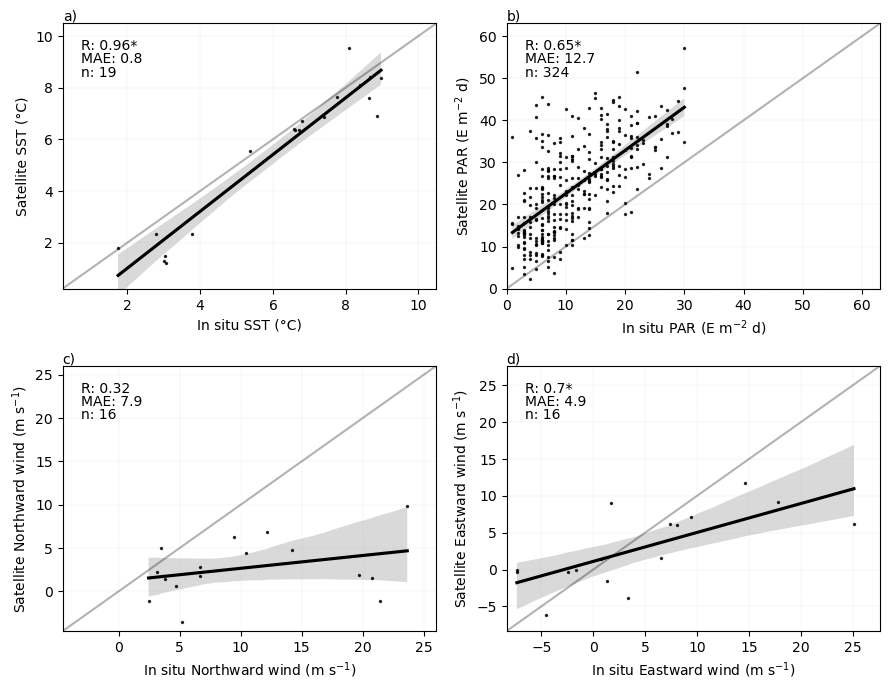

In [5]:
# library
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.metrics import mean_absolute_error
import string
# plot data
fig = plt.figure(figsize=(9, 7))
i = 1
for df_i in [df_sst, df_par, df_nw, df_ew]:
    ax = plt.subplot(2, 2, i)
    sns.regplot(x=df_i.columns[1],
            y=df_i.columns[0],
            data=df_i,
            ax=ax,
            color="k",
               scatter_kws={'s':2})
    
    ax.plot([-30, 70],
            [-30, 70],
            color="k",
            alpha=0.3)
    
    min_lim = df_i.min().min()-1
    max_lim = df_i.max().max()*1.1
    ax.set_ylim(min_lim,
                max_lim)
    ax.set_xlim(min_lim,
                max_lim)
    ax.grid(linestyle="--",
            linewidth=0.1)
    
    # write statistics
    x = df_i.iloc[:,0]
    y = df_i.iloc[:,1]
    r, pvalue = pearsonr(x, y)
    mae = mean_absolute_error(x, y)
    n = len(x)
    if pvalue<0.05:
        sign = "*"
        
    else:
        sign = ""
        
    ax.text(((ax.get_xlim()[1]-ax.get_xlim()[0])*0.05)+ax.get_xlim()[0],
            ((ax.get_ylim()[1]-ax.get_ylim()[0])*0.9)+ax.get_ylim()[0],
            "R: "+str(np.round(r, 2))+sign)
    
    ax.text(((ax.get_xlim()[1]-ax.get_xlim()[0])*0.05)+ax.get_xlim()[0],
            ((ax.get_ylim()[1]-ax.get_ylim()[0])*0.85)+ax.get_ylim()[0],
            "MAE: "+str(np.round(mae, 1)))
    
    ax.text(((ax.get_xlim()[1]-ax.get_xlim()[0])*0.05)+ax.get_xlim()[0],
            ((ax.get_ylim()[1]-ax.get_ylim()[0])*0.8)+ax.get_ylim()[0],
            "n: "+str(n))
    ax.text(((ax.get_xlim()[1]-ax.get_xlim()[0])*0.0)+ax.get_xlim()[0],
            ((ax.get_ylim()[1]-ax.get_ylim()[0])*1.01)+ax.get_ylim()[0],
            string.ascii_lowercase[i-1]+")")
    i = i+1
plt.tight_layout()
fig.savefig(path_out, dpi=300)